## 1. Install Dependencies

In [1]:
!pip install lpips
!pip install torchvision
!pip install piq
!pip install scikit-image
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 5.9 MB/s eta 0:00:00


## 2. Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from pytorch_msssim import ssim
import lpips
from piq import gmsd
from skimage.color import rgb2lab, deltaE_ciede2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 3. CIFAR-10 Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 30.6MB/s]


## 4. Straight-Through Estimator (Binarization)

In [4]:
class BinarizeSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Hard thresholding to {0,1}
        return (x > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through: pass gradients unchanged
        return grad_output

binarize = BinarizeSTE.apply

 ## 5A. Binary Latent Autoencoder

In [5]:
class BinaryAutoencoder(nn.Module):
    def __init__(self, latent_dim=1024, epsilon=1e-4):
        super().__init__()
        self.epsilon = epsilon

        # Encoder: (B,3,32,32) -> (B,128,4,4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),      # 32x16x16
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),     # 64x8x8
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),    # 128x4x4
        )

        self.fc_enc = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 128 * 4 * 4)

        # Decoder: (B,128,4,4) -> (B,3,32,32)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),     # 64x8x8
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),      # 32x16x16
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid(),    # 3x32x32 in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        z = self.fc_enc(x)
        z = torch.tanh(z)

        z = z + self.epsilon * torch.randn_like(z)

        z_bin = binarize(z)
        z_bin = z + (z_bin - z).detach()

        x = self.fc_dec(z_bin)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)

        return x, z_bin

## 5B. Binary Autoencoder with MDL Output Head

In [6]:
class BinaryAutoencoderMDL(nn.Module):
    def __init__(self, latent_dim=1024, epsilon=1e-4, nr_mix=10):
        super().__init__()
        self.epsilon = epsilon
        self.nr_mix = nr_mix

        # Encoder identical to BinaryAutoencoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
        )

        self.fc_enc = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 128 * 4 * 4)

        # Decoder outputs MDL params instead of pixels
        # For each of 3 channels: (logit_probs, means, log_scales) * nr_mix
        out_ch = 3 * 3 * nr_mix
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, out_ch, 4, 2, 1)  # No activation
        )

    def forward(self, x):
        # x expected in [-1,1]
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        z = self.fc_enc(x)
        z = torch.tanh(z)
        z = z + self.epsilon * torch.randn_like(z)

        z_bin = binarize(z)
        z_bin = z + (z_bin - z).detach()

        x = self.fc_dec(z_bin)
        x = x.view(-1, 128, 4, 4)
        dist_params = self.decoder(x)  # (B, 3*3*nr_mix, 32, 32)

        return dist_params, z_bin

## 6A. Loss Functions (Pixel-wise + Perceptual + Normalized Combined)

In [7]:
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
lpips_loss = lpips.LPIPS(net="alex").to(device)

def to_lpips_range(x):
    # LPIPS expects [-1,1]
    return x * 2 - 1

# Correct SSIM loss: pred, target in [0,1]
def ssim_loss(pred, target):
    # SSIM similarity -> convert to loss
    return 1.0 - ssim(pred, target, data_range=1.0, size_average=True)

# ---------------- Gradient (Sobel) Loss ----------------
def sobel_gradient(img):
    gx = torch.tensor([[[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]]],
                      dtype=torch.float32, device=img.device)
    gy = torch.tensor([[[-1,-2,-1],
                        [ 0, 0, 0],
                        [ 1, 2, 1]]],
                      dtype=torch.float32, device=img.device)

    gx, gy = gx.unsqueeze(0), gy.unsqueeze(0)

    grad_x = F.conv2d(
        img,
        gx.expand(img.size(1), -1, -1, -1),
        padding=1,
        groups=img.size(1)
    )
    grad_y = F.conv2d(
        img,
        gy.expand(img.size(1), -1, -1, -1),
        padding=1,
        groups=img.size(1)
    )
    return grad_x, grad_y

def gradient_loss(img, recon):
    gx1, gy1 = sobel_gradient(img)
    gx2, gy2 = sobel_gradient(recon)
    return (torch.abs(gx1 - gx2).mean() +
            torch.abs(gy1 - gy2).mean())

# ---------------- Static Normalization for Combined Loss (Option A) ----------------
loss_stats = {
    "gl": {"mean": 0.10, "std": 0.05},
    "ss": {"mean": 0.25, "std": 0.05},
    "lp": {"mean": 0.40, "std": 0.10},
    "l1": {"mean": 0.06, "std": 0.02},
}

def combined_loss(img, recon):
    # img, recon in [0,1]
    gl = gradient_loss(img, recon)
    ss = ssim_loss(recon, img)
    lp = lpips_loss(to_lpips_range(recon), to_lpips_range(img)).mean()
    l1 = mae_loss(recon, img)

    gl_n = (gl - loss_stats["gl"]["mean"]) / (loss_stats["gl"]["std"] + 1e-8)
    ss_n = (ss - loss_stats["ss"]["mean"]) / (loss_stats["ss"]["std"] + 1e-8)
    lp_n = (lp - loss_stats["lp"]["mean"]) / (loss_stats["lp"]["std"] + 1e-8)
    l1_n = (l1 - loss_stats["l1"]["mean"]) / (loss_stats["l1"]["std"] + 1e-8)

    # Weighted sum (normalized)
    return 0.5*gl_n + 0.3*ss_n + 0.2*lp_n + 0.1*l1_n

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 147MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


## 6B. Mixture of Discretized Logistics Loss (MDL)

In [8]:
def discretized_mix_logistic_loss(x, l, nr_mix=10):
    """
    x: (B, C, H, W) in [-1, 1]
    l: (B, C * 3 * nr_mix, H, W)
    """
    B, C, H, W = x.shape

    # (B, H, W, C*3*nr_mix)
    l = l.permute(0, 2, 3, 1)
    # (B, H, W, C, 3*nr_mix)
    l = l.view(B, H, W, C, 3 * nr_mix)

    logit_probs = l[..., :nr_mix]
    means       = l[..., nr_mix:2*nr_mix]
    log_scales  = l[..., 2*nr_mix:3*nr_mix]
    log_scales  = torch.clamp(log_scales, min=-7.)

    x = x.permute(0, 2, 3, 1).unsqueeze(-1)   # (B,H,W,C,1)

    inv_stdv = torch.exp(-log_scales)
    plus  = inv_stdv * (x + 1.0/255.0 - means)
    minus = inv_stdv * (x - 1.0/255.0 - means)

    cdf_plus  = torch.sigmoid(plus)
    cdf_minus = torch.sigmoid(minus)

    cdf_delta = torch.clamp(cdf_plus - cdf_minus, min=1e-12)
    log_probs = torch.log(cdf_delta)

    log_mix = F.log_softmax(logit_probs, dim=-1)
    log_prob = log_probs + log_mix  # (B,H,W,C,K)

    loss = -torch.logsumexp(log_prob, dim=-1)  # (B,H,W,C)
    return loss.mean()

# =====================================================
# Helper: reconstruct mean image from MDL parameters
# =====================================================
def mdl_reconstruct_mean(dist_params, nr_mix=10):
    """
    dist_params: (B, C*3*nr_mix, H, W), C=3
    returns: mean image in [-1,1], shape (B,3,H,W)
    """
    B, C3K, H, W = dist_params.shape
    C = 3

    l = dist_params.permute(0, 2, 3, 1)     # (B,H,W,C*3K)
    l = l.view(B, H, W, C, 3 * nr_mix)      # (B,H,W,C,3K)

    logit_probs = l[..., :nr_mix]           # (B,H,W,C,K)
    means       = l[..., nr_mix:2*nr_mix]   # (B,H,W,C,K)

    log_mix = F.log_softmax(logit_probs, dim=-1)
    pi = torch.exp(log_mix)                 # (B,H,W,C,K)

    mean = (pi * means).sum(dim=-1)         # (B,H,W,C)
    mean = mean.permute(0, 3, 1, 2)         # (B,C,H,W)
    return torch.clamp(mean, -1.0, 1.0)

## 7. Evaluation Metric Utilities

In [9]:
def cosine_distance(x, y):
    x = x.reshape(x.size(0), -1)
    y = y.reshape(y.size(0), -1)
    return (1 - F.cosine_similarity(x, y)).mean()

def gmsd_distance(x, y):
    return gmsd(x, y).mean()

def deltaE2000_distance(img, recon):
    img_np = img.permute(0,2,3,1).cpu().numpy()
    rec_np = recon.permute(0,2,3,1).cpu().numpy()

    total = 0
    for i in range(img_np.shape[0]):
        delta = deltaE_ciede2000(rgb2lab(img_np[i]), rgb2lab(rec_np[i]))
        total += delta.mean()
    return total / img_np.shape[0]

## 8A. Training (Original Models: MSE/MAE/SSIM/LPIPS/Combined)

In [10]:
def train_model(loss_name, epochs=60):
    model = BinaryAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    print(f"\nTraining {loss_name.upper()} model...\n")
    epoch_losses = []

    for epoch in range(epochs):
        batch_losses = []

        for imgs, _ in train_loader:
            imgs = imgs.to(device)  # [0,1]
            outputs, _ = model(imgs)

            if loss_name == "mse":
                loss = mse_loss(outputs, imgs)
            elif loss_name == "mae":
                loss = mae_loss(outputs, imgs)
            elif loss_name == "ssim":
                loss = ssim_loss(outputs, imgs)
            elif loss_name == "lpips":
                loss = lpips_loss(to_lpips_range(outputs),
                                  to_lpips_range(imgs)).mean()
            elif loss_name == "combined":
                loss = combined_loss(imgs, outputs)
            else:
                raise ValueError("Unknown loss type.")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} | {loss_name} Loss: {epoch_loss:.4f}")

    return model, epoch_losses

## 8B. Training for MDL Model

In [11]:
def train_model_mdl(epochs=60, nr_mix=10):
    model = BinaryAutoencoderMDL(nr_mix=nr_mix).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    print(f"\nTraining MDL model (nr_mix={nr_mix})...\n")
    epoch_losses = []

    for epoch in range(epochs):
        batch_losses = []

        for imgs, _ in train_loader:
            imgs = imgs.to(device)  # [0,1]
            x = imgs * 2 - 1        # [-1,1] for MDL

            dist_params, _ = model(x)
            loss = discretized_mix_logistic_loss(x, dist_params, nr_mix=nr_mix)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} | MDL NLL: {epoch_loss:.4f}")

    return model, epoch_losses

## 9. Train All Models

In [12]:
model_mse,   mse_curve   = train_model("mse")


Training MSE model...

Epoch 1/60 | mse Loss: 0.0266
Epoch 2/60 | mse Loss: 0.0148
Epoch 3/60 | mse Loss: 0.0125
Epoch 4/60 | mse Loss: 0.0113
Epoch 5/60 | mse Loss: 0.0104
Epoch 6/60 | mse Loss: 0.0098
Epoch 7/60 | mse Loss: 0.0092
Epoch 8/60 | mse Loss: 0.0087
Epoch 9/60 | mse Loss: 0.0082
Epoch 10/60 | mse Loss: 0.0079
Epoch 11/60 | mse Loss: 0.0076
Epoch 12/60 | mse Loss: 0.0073
Epoch 13/60 | mse Loss: 0.0072
Epoch 14/60 | mse Loss: 0.0070
Epoch 15/60 | mse Loss: 0.0068
Epoch 16/60 | mse Loss: 0.0066
Epoch 17/60 | mse Loss: 0.0065
Epoch 18/60 | mse Loss: 0.0064
Epoch 19/60 | mse Loss: 0.0063
Epoch 20/60 | mse Loss: 0.0062
Epoch 21/60 | mse Loss: 0.0061
Epoch 22/60 | mse Loss: 0.0060
Epoch 23/60 | mse Loss: 0.0059
Epoch 24/60 | mse Loss: 0.0058
Epoch 25/60 | mse Loss: 0.0057
Epoch 26/60 | mse Loss: 0.0057
Epoch 27/60 | mse Loss: 0.0056
Epoch 28/60 | mse Loss: 0.0055
Epoch 29/60 | mse Loss: 0.0055
Epoch 30/60 | mse Loss: 0.0054
Epoch 31/60 | mse Loss: 0.0054
Epoch 32/60 | mse Loss: 

In [13]:
model_mae,   mae_curve   = train_model("mae")


Training MAE model...

Epoch 1/60 | mae Loss: 0.1282
Epoch 2/60 | mae Loss: 0.0928
Epoch 3/60 | mae Loss: 0.0839
Epoch 4/60 | mae Loss: 0.0790
Epoch 5/60 | mae Loss: 0.0759
Epoch 6/60 | mae Loss: 0.0725
Epoch 7/60 | mae Loss: 0.0702
Epoch 8/60 | mae Loss: 0.0686
Epoch 9/60 | mae Loss: 0.0670
Epoch 10/60 | mae Loss: 0.0657
Epoch 11/60 | mae Loss: 0.0645
Epoch 12/60 | mae Loss: 0.0634
Epoch 13/60 | mae Loss: 0.0625
Epoch 14/60 | mae Loss: 0.0617
Epoch 15/60 | mae Loss: 0.0610
Epoch 16/60 | mae Loss: 0.0602
Epoch 17/60 | mae Loss: 0.0595
Epoch 18/60 | mae Loss: 0.0589
Epoch 19/60 | mae Loss: 0.0584
Epoch 20/60 | mae Loss: 0.0579
Epoch 21/60 | mae Loss: 0.0573
Epoch 22/60 | mae Loss: 0.0570
Epoch 23/60 | mae Loss: 0.0565
Epoch 24/60 | mae Loss: 0.0561
Epoch 25/60 | mae Loss: 0.0558
Epoch 26/60 | mae Loss: 0.0554
Epoch 27/60 | mae Loss: 0.0550
Epoch 28/60 | mae Loss: 0.0548
Epoch 29/60 | mae Loss: 0.0545
Epoch 30/60 | mae Loss: 0.0542
Epoch 31/60 | mae Loss: 0.0539
Epoch 32/60 | mae Loss: 

In [14]:
model_ssim,  ssim_curve  = train_model("ssim")


Training SSIM model...

Epoch 1/60 | ssim Loss: 0.5158
Epoch 2/60 | ssim Loss: 0.3260
Epoch 3/60 | ssim Loss: 0.2800
Epoch 4/60 | ssim Loss: 0.2576
Epoch 5/60 | ssim Loss: 0.2419
Epoch 6/60 | ssim Loss: 0.2286
Epoch 7/60 | ssim Loss: 0.2176
Epoch 8/60 | ssim Loss: 0.2085
Epoch 9/60 | ssim Loss: 0.2012
Epoch 10/60 | ssim Loss: 0.1955
Epoch 11/60 | ssim Loss: 0.1905
Epoch 12/60 | ssim Loss: 0.1861
Epoch 13/60 | ssim Loss: 0.1823
Epoch 14/60 | ssim Loss: 0.1786
Epoch 15/60 | ssim Loss: 0.1751
Epoch 16/60 | ssim Loss: 0.1721
Epoch 17/60 | ssim Loss: 0.1694
Epoch 18/60 | ssim Loss: 0.1668
Epoch 19/60 | ssim Loss: 0.1642
Epoch 20/60 | ssim Loss: 0.1621
Epoch 21/60 | ssim Loss: 0.1602
Epoch 22/60 | ssim Loss: 0.1580
Epoch 23/60 | ssim Loss: 0.1564
Epoch 24/60 | ssim Loss: 0.1546
Epoch 25/60 | ssim Loss: 0.1530
Epoch 26/60 | ssim Loss: 0.1514
Epoch 27/60 | ssim Loss: 0.1498
Epoch 28/60 | ssim Loss: 0.1486
Epoch 29/60 | ssim Loss: 0.1473
Epoch 30/60 | ssim Loss: 0.1460
Epoch 31/60 | ssim Loss:

In [15]:
model_lpips, lpips_curve = train_model("lpips")


Training LPIPS model...

Epoch 1/60 | lpips Loss: 0.1291
Epoch 2/60 | lpips Loss: 0.0951
Epoch 3/60 | lpips Loss: 0.0724
Epoch 4/60 | lpips Loss: 0.0621
Epoch 5/60 | lpips Loss: 0.0550
Epoch 6/60 | lpips Loss: 0.0497
Epoch 7/60 | lpips Loss: 0.0456
Epoch 8/60 | lpips Loss: 0.0427
Epoch 9/60 | lpips Loss: 0.0401
Epoch 10/60 | lpips Loss: 0.0379
Epoch 11/60 | lpips Loss: 0.0358
Epoch 12/60 | lpips Loss: 0.0342
Epoch 13/60 | lpips Loss: 0.0327
Epoch 14/60 | lpips Loss: 0.0313
Epoch 15/60 | lpips Loss: 0.0300
Epoch 16/60 | lpips Loss: 0.0287
Epoch 17/60 | lpips Loss: 0.0277
Epoch 18/60 | lpips Loss: 0.0268
Epoch 19/60 | lpips Loss: 0.0259
Epoch 20/60 | lpips Loss: 0.0252
Epoch 21/60 | lpips Loss: 0.0244
Epoch 22/60 | lpips Loss: 0.0237
Epoch 23/60 | lpips Loss: 0.0231
Epoch 24/60 | lpips Loss: 0.0224
Epoch 25/60 | lpips Loss: 0.0219
Epoch 26/60 | lpips Loss: 0.0214
Epoch 27/60 | lpips Loss: 0.0208
Epoch 28/60 | lpips Loss: 0.0203
Epoch 29/60 | lpips Loss: 0.0199
Epoch 30/60 | lpips Loss: 

In [16]:
model_comb,  comb_curve  = train_model("combined")


Training COMBINED model...

Epoch 1/60 | combined Loss: 7.5918
Epoch 2/60 | combined Loss: 5.0441
Epoch 3/60 | combined Loss: 4.1728
Epoch 4/60 | combined Loss: 3.6451
Epoch 5/60 | combined Loss: 3.2932
Epoch 6/60 | combined Loss: 3.0411
Epoch 7/60 | combined Loss: 2.8376
Epoch 8/60 | combined Loss: 2.6588
Epoch 9/60 | combined Loss: 2.4979
Epoch 10/60 | combined Loss: 2.3669
Epoch 11/60 | combined Loss: 2.2496
Epoch 12/60 | combined Loss: 2.1479
Epoch 13/60 | combined Loss: 2.0494
Epoch 14/60 | combined Loss: 1.9640
Epoch 15/60 | combined Loss: 1.8862
Epoch 16/60 | combined Loss: 1.8100
Epoch 17/60 | combined Loss: 1.7364
Epoch 18/60 | combined Loss: 1.6810
Epoch 19/60 | combined Loss: 1.6226
Epoch 20/60 | combined Loss: 1.5696
Epoch 21/60 | combined Loss: 1.5181
Epoch 22/60 | combined Loss: 1.4747
Epoch 23/60 | combined Loss: 1.4298
Epoch 24/60 | combined Loss: 1.3907
Epoch 25/60 | combined Loss: 1.3487
Epoch 26/60 | combined Loss: 1.3134
Epoch 27/60 | combined Loss: 1.2824
Epoch 28

In [17]:
nr_mix = 10
model_mdl,  mdl_curve    = train_model_mdl(epochs=60, nr_mix=nr_mix)


Training MDL model (nr_mix=10)...

Epoch 1/60 | MDL NLL: 5.4314
Epoch 2/60 | MDL NLL: 4.9208
Epoch 3/60 | MDL NLL: 4.6865
Epoch 4/60 | MDL NLL: 4.5789
Epoch 5/60 | MDL NLL: 4.5258
Epoch 6/60 | MDL NLL: 4.4890
Epoch 7/60 | MDL NLL: 4.4595
Epoch 8/60 | MDL NLL: 4.4396
Epoch 9/60 | MDL NLL: 4.4136
Epoch 10/60 | MDL NLL: 4.3935
Epoch 11/60 | MDL NLL: 4.3770
Epoch 12/60 | MDL NLL: 4.3515
Epoch 13/60 | MDL NLL: 4.3270
Epoch 14/60 | MDL NLL: 4.3081
Epoch 15/60 | MDL NLL: 4.2934
Epoch 16/60 | MDL NLL: 4.2738
Epoch 17/60 | MDL NLL: 4.2638
Epoch 18/60 | MDL NLL: 4.2534
Epoch 19/60 | MDL NLL: 4.2408
Epoch 20/60 | MDL NLL: 4.2317
Epoch 21/60 | MDL NLL: 4.2232
Epoch 22/60 | MDL NLL: 4.2133
Epoch 23/60 | MDL NLL: 4.2065
Epoch 24/60 | MDL NLL: 4.1983
Epoch 25/60 | MDL NLL: 4.1894
Epoch 26/60 | MDL NLL: 4.1821
Epoch 27/60 | MDL NLL: 4.1775
Epoch 28/60 | MDL NLL: 4.1703
Epoch 29/60 | MDL NLL: 4.1651
Epoch 30/60 | MDL NLL: 4.1599
Epoch 31/60 | MDL NLL: 4.1545
Epoch 32/60 | MDL NLL: 4.1469
Epoch 33/60 |

## 10. Plot Loss Curves

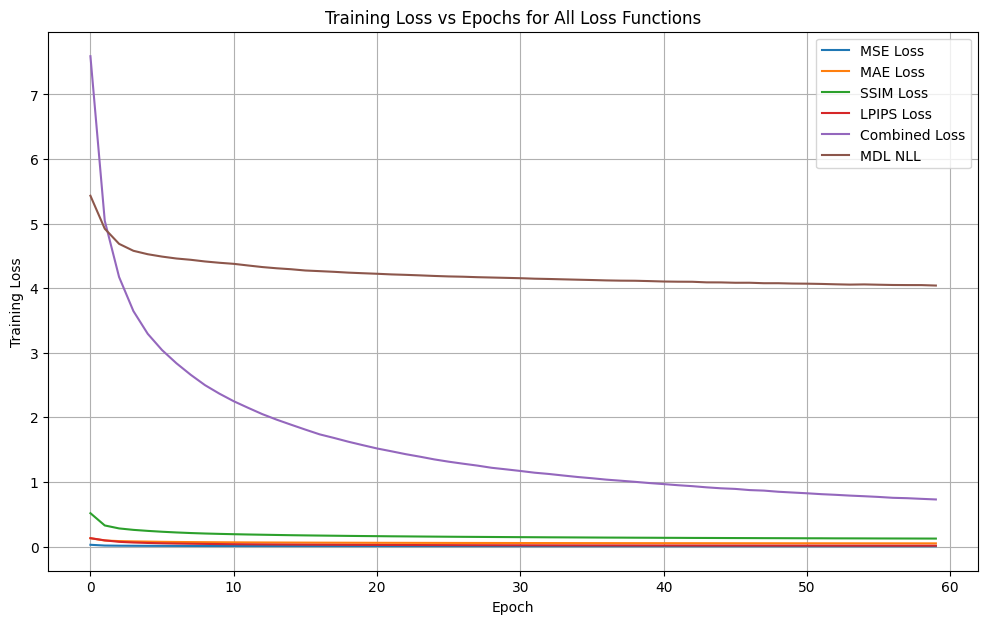

In [18]:
plt.figure(figsize=(12,7))
plt.plot(mse_curve,   label="MSE Loss")
plt.plot(mae_curve,   label="MAE Loss")
plt.plot(ssim_curve,  label="SSIM Loss")
plt.plot(lpips_curve, label="LPIPS Loss")
plt.plot(comb_curve,  label="Combined Loss")
plt.plot(mdl_curve,   label="MDL NLL")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs for All Loss Functions")
plt.legend()
plt.grid(True)
plt.show()

## 11. Visualization Helpers

In [19]:
def visualize_model(model, title="Model Output"):
    model.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        recon, _ = model(imgs)

    fig, axs = plt.subplots(1, 2, figsize=(20,10))

    axs[0].imshow(
        vutils.make_grid(imgs[:32], normalize=True, nrow=8).permute(1,2,0).cpu()
    )
    axs[0].set_title("Original", fontsize=24)
    axs[0].axis("off")

    axs[1].imshow(
        vutils.make_grid(recon[:32], normalize=True, nrow=8).permute(1,2,0).cpu()
    )
    axs[1].set_title(title, fontsize=24)
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

def visualize_mdl_model(model, title="Reconstruction (MDL Loss)", nr_mix=10):
    model.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)        # [0,1]
    x = imgs * 2 - 1              # [-1,1]

    with torch.no_grad():
        dist_params, _ = model(x)
        recon_m11 = mdl_reconstruct_mean(dist_params, nr_mix=nr_mix)  # [-1,1]
        recon = (recon_m11 + 1) / 2                                   # [0,1]

    fig, axs = plt.subplots(1, 2, figsize=(20,10))

    axs[0].imshow(
        vutils.make_grid(imgs[:32], normalize=True, nrow=8).permute(1,2,0).cpu()
    )
    axs[0].set_title("Original", fontsize=24)
    axs[0].axis("off")

    axs[1].imshow(
        vutils.make_grid(recon[:32], normalize=True, nrow=8).permute(1,2,0).cpu()
    )
    axs[1].set_title(title, fontsize=24)
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

## 12. Visualize All Models

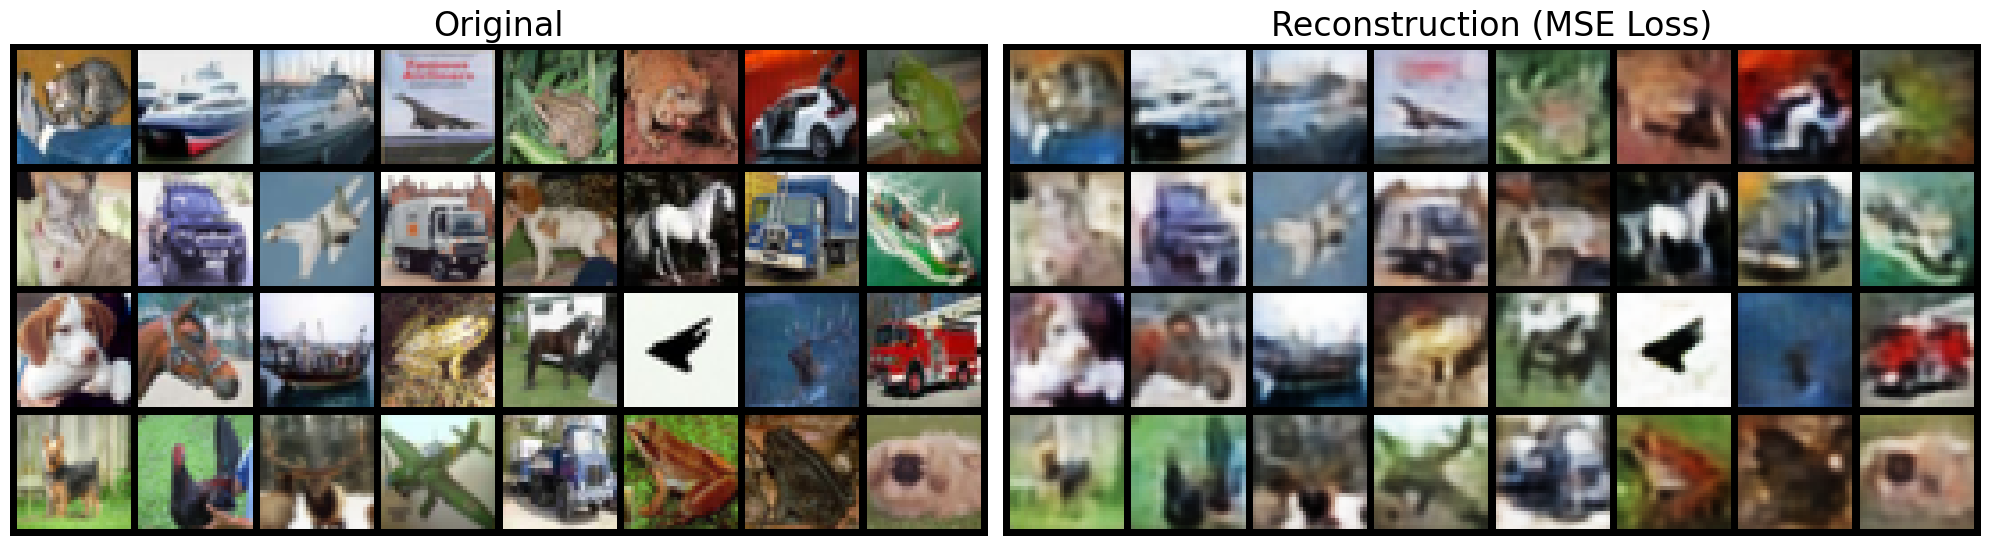

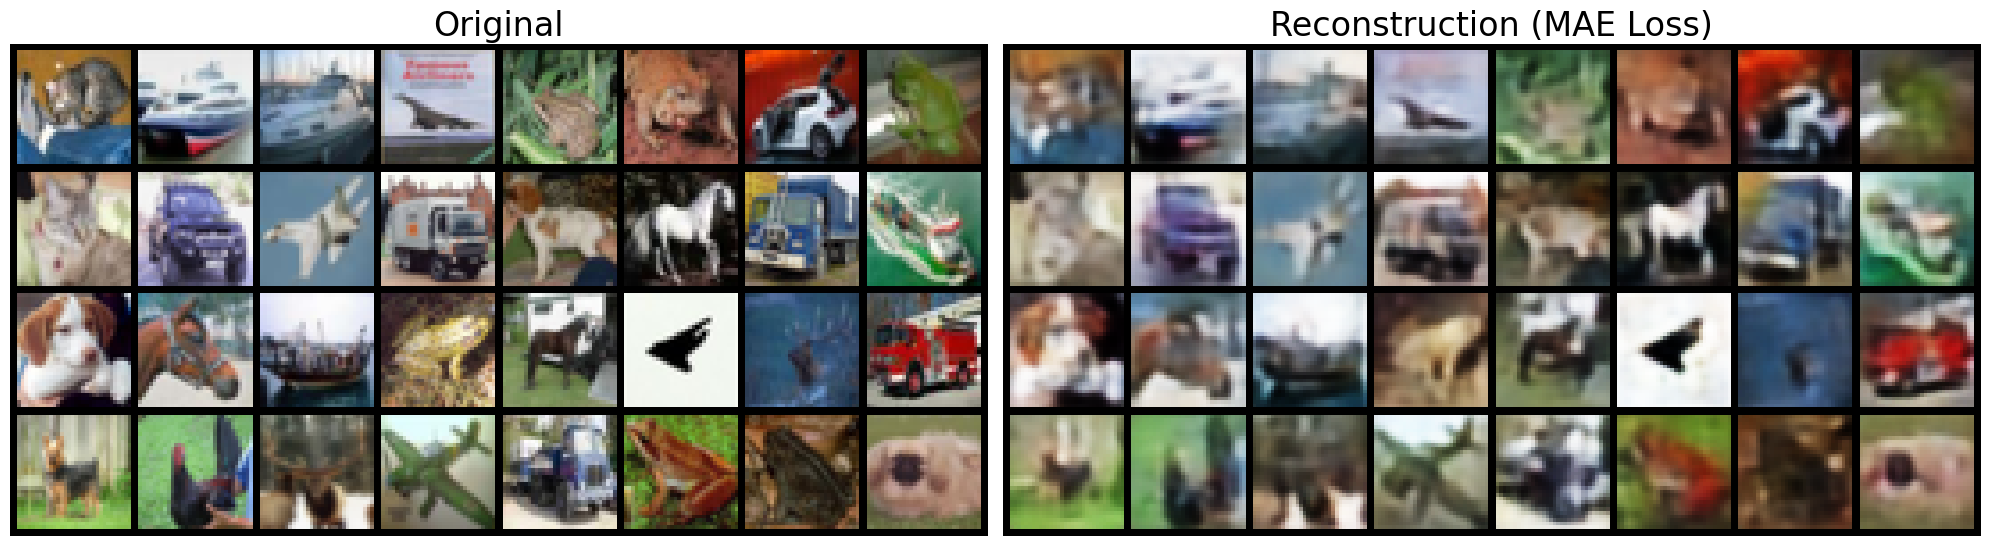

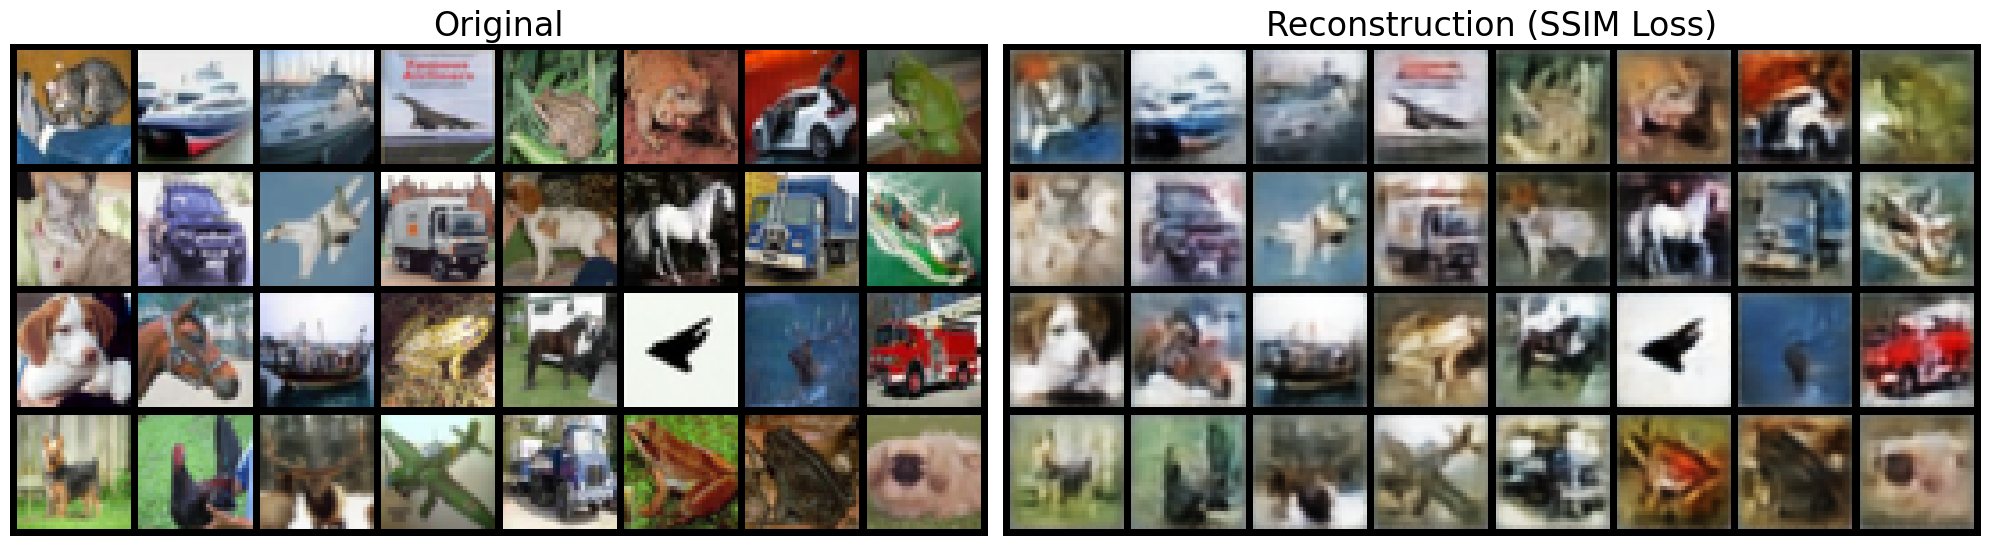

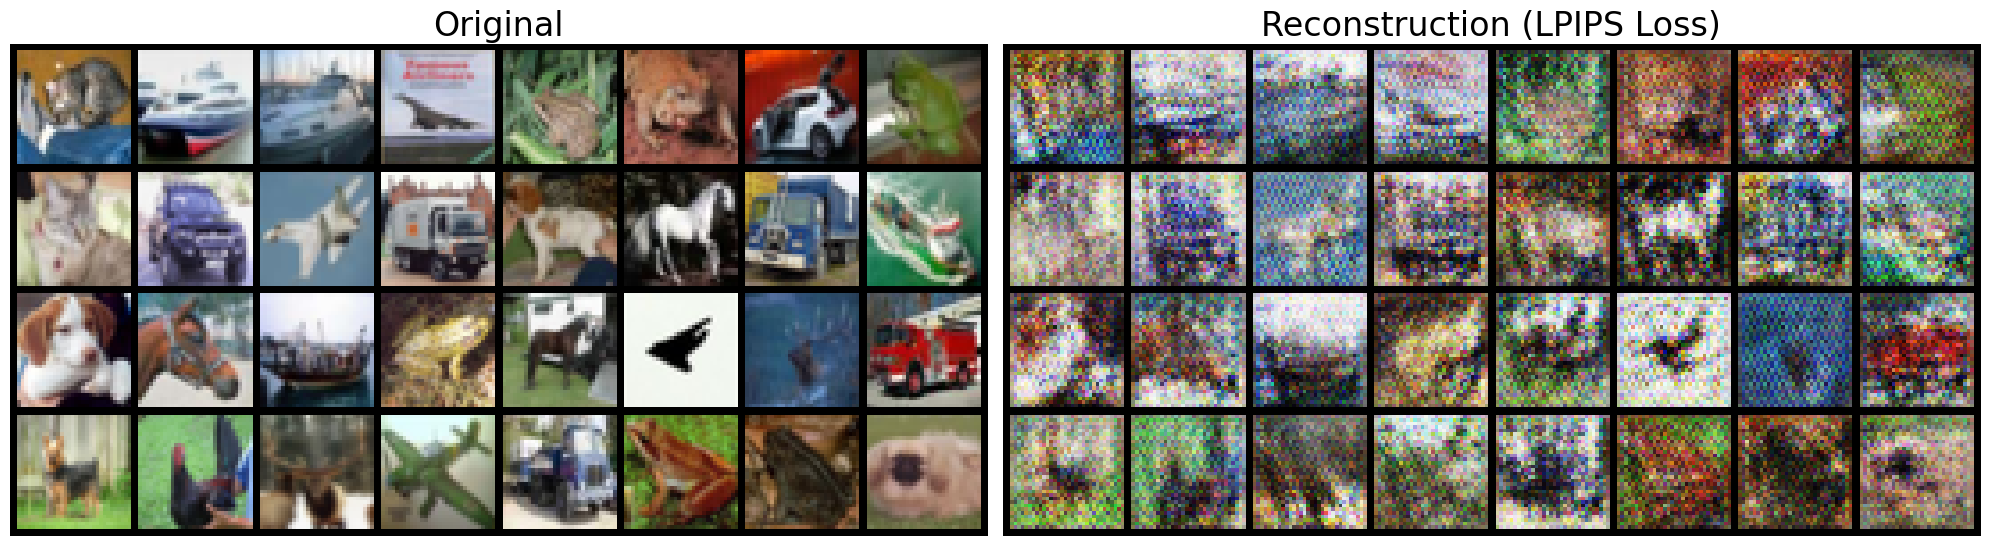

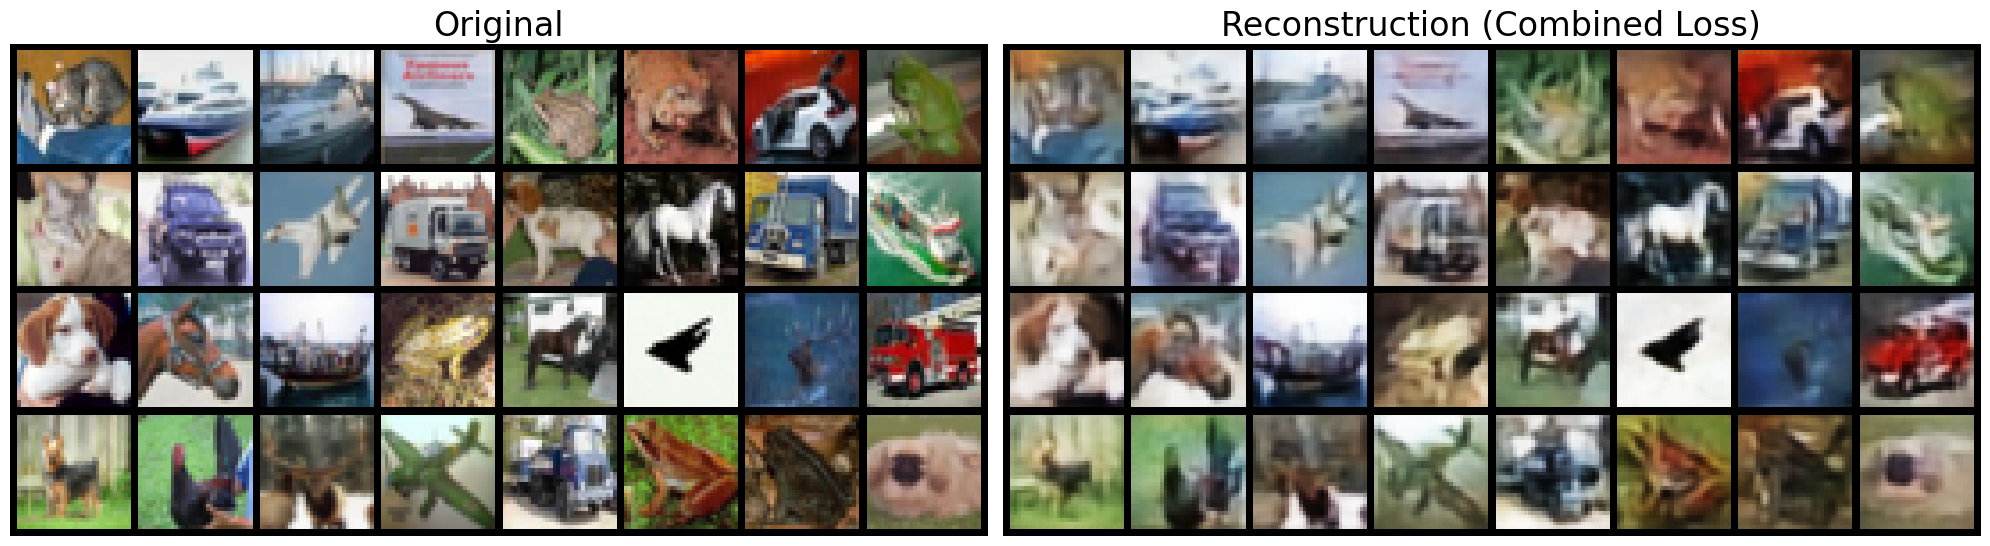

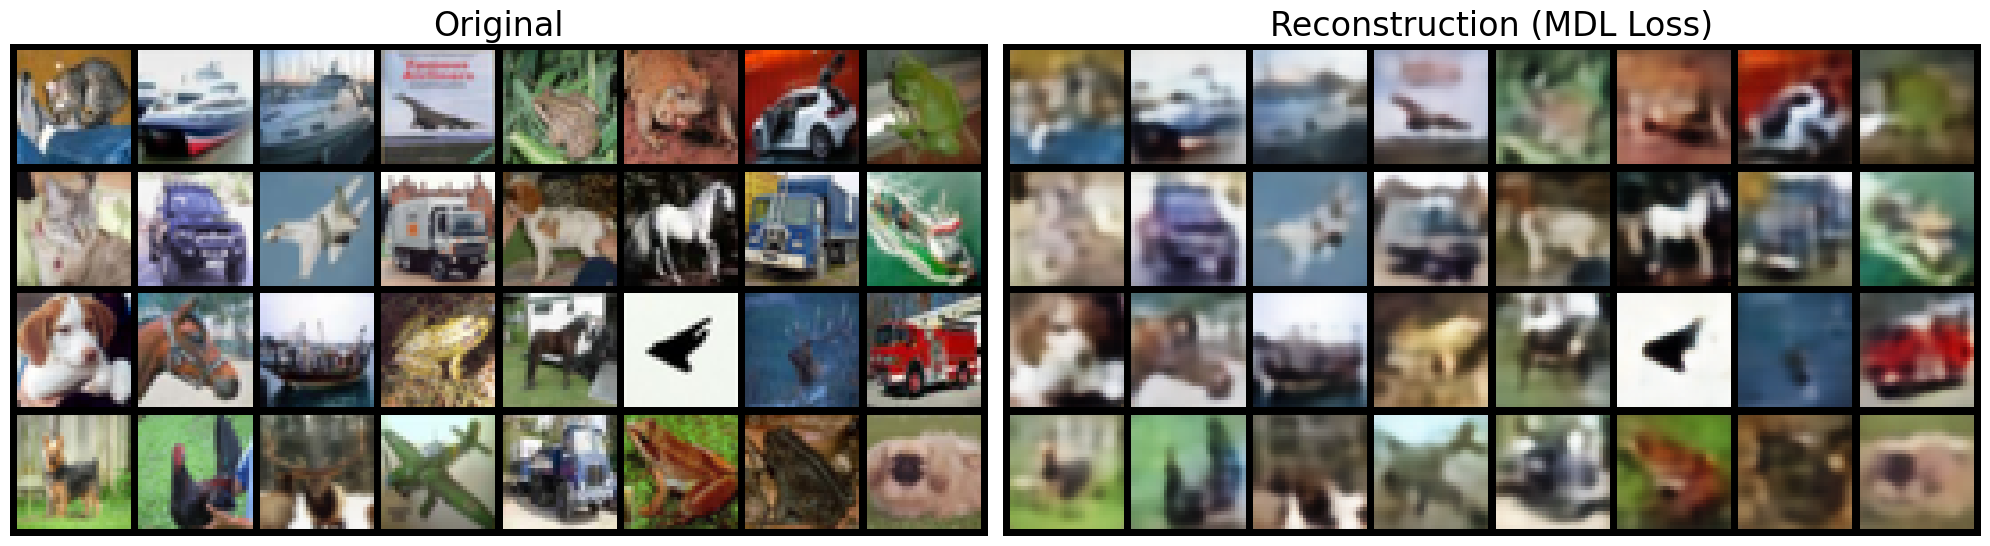

In [20]:
visualize_model(model_mse,   "Reconstruction (MSE Loss)")
visualize_model(model_mae,   "Reconstruction (MAE Loss)")
visualize_model(model_ssim,  "Reconstruction (SSIM Loss)")
visualize_model(model_lpips, "Reconstruction (LPIPS Loss)")
visualize_model(model_comb,  "Reconstruction (Combined Loss)")
visualize_mdl_model(model_mdl, "Reconstruction (MDL Loss)", nr_mix=nr_mix)

## METRICS AND UTILITY FUNCTIONS

In [21]:
# --- PSNR ---
def psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse + 1e-8))


# --- Noise level (absolute residual noise) ---
def noise_level(recon, img):
    return (recon - img).abs().mean().item()


# --- High frequency noise (Sobel difference) ---
def high_freq_noise(recon, img):
    gx_r, gy_r = sobel_gradient(recon)
    gx_i, gy_i = sobel_gradient(img)
    return ((gx_r - gx_i).abs().mean() + (gy_r - gy_i).abs().mean()).item()


# --- Inference time measurement ---
def measure_inference_time(model, batch_size=1, repeats=20):
    model.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:batch_size].to(device)

    # Warmup
    with torch.no_grad():
        model(imgs)

    start = time.time()
    with torch.no_grad():
        for _ in range(repeats):
            model(imgs)
    end = time.time()

    return (end - start) / repeats  # seconds per batch


# --- Parameter count ---
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## 13A. Evaluation

In [22]:
def evaluate_model(model):
    model.eval()

    mse_total = ssim_total = lp_total = 0
    cos_total = gmsd_total = de_total = 0
    psnr_total = noise_total = hfnoise_total = 0
    comb_total = 0
    count = 0

    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)  # [0,1]
            recon, _ = model(imgs)

            mse_total   += mse_loss(recon, imgs).item()
            ssim_total  += ssim(recon, imgs, data_range=1.0, size_average=True).item()
            lp_total    += lpips_loss(to_lpips_range(recon), to_lpips_range(imgs)).mean().item()
            cos_total   += cosine_distance(imgs, recon).item()
            gmsd_total  += gmsd_distance(imgs, recon).item()
            de_total    += deltaE2000_distance(imgs, recon)
            psnr_total  += psnr(recon, imgs).item()
            noise_total += noise_level(recon, imgs)
            hfnoise_total += high_freq_noise(recon, imgs)
            comb_total += combined_loss(imgs, recon).item()

            count += 1

    return {
        "MSE": mse_total / count,
        "SSIM": ssim_total / count,
        "LPIPS": lp_total / count,
        "Cosine": cos_total / count,
        "GMSD": gmsd_total / count,
        "DeltaE2000": de_total / count,
        "PSNR": psnr_total / count,
        "NoiseLevel": noise_total / count,
        "HighFreqNoise": hfnoise_total / count,
        "CombinedScore": comb_total / count,
        "InferenceTime(sec)": measure_inference_time(model),
        "Params": count_params(model),
    }


## 13B. Evaluation for MDL Model

In [23]:
def evaluate_mdl_model(model, nr_mix=10):
    model.eval()

    mse_total = ssim_total = lp_total = 0
    cos_total = gmsd_total = de_total = 0
    psnr_total = noise_total = hfnoise_total = 0
    comb_total = 0
    count = 0

    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)   # [0,1]
            x = imgs * 2 - 1         # [-1,1]

            dist_params, _ = model(x)
            recon_m11 = mdl_reconstruct_mean(dist_params, nr_mix=nr_mix)
            recon = (recon_m11 + 1) / 2   # back to [0,1]

            mse_total   += mse_loss(recon, imgs).item()
            ssim_total  += ssim(recon, imgs, data_range=1.0, size_average=True).item()
            lp_total    += lpips_loss(to_lpips_range(recon), to_lpips_range(imgs)).mean().item()
            cos_total   += cosine_distance(imgs, recon).item()
            gmsd_total  += gmsd_distance(imgs, recon).item()
            de_total    += deltaE2000_distance(imgs, recon)
            psnr_total  += psnr(recon, imgs).item()
            noise_total += noise_level(recon, imgs)
            hfnoise_total += high_freq_noise(recon, imgs)
            comb_total += combined_loss(imgs, recon).item()

            count += 1

    return {
        "MSE": mse_total / count,
        "SSIM": ssim_total / count,
        "LPIPS": lp_total / count,
        "Cosine": cos_total / count,
        "GMSD": gmsd_total / count,
        "DeltaE2000": de_total / count,
        "PSNR": psnr_total / count,
        "NoiseLevel": noise_total / count,
        "HighFreqNoise": hfnoise_total / count,
        "CombinedScore": comb_total / count,
        "InferenceTime(sec)": measure_inference_time(model),
        "Params": count_params(model),
    }


## 14. Final Results Table

In [24]:
results_dict = {
    "MSE/L2 Model":                      evaluate_model(model_mse),
    "MAE/L1 Model":                      evaluate_model(model_mae),
    "SSIM Model":                        evaluate_model(model_ssim),
    "LPIPS Model":                       evaluate_model(model_lpips),
    "Combined(GL + SSIM + LPIPS + L1)":  evaluate_model(model_comb),
    "MDL Model":                         evaluate_mdl_model(model_mdl, nr_mix=nr_mix),
}

df_results = pd.DataFrame(results_dict).T
display(df_results)

,MSE,SSIM,LPIPS,Cosine,GMSD,DeltaE2000,PSNR,NoiseLevel,HighFreqNoise,CombinedScore,InferenceTime(sec),Params
MSE/L2 Model,0.005054,0.791313,0.060336,0.010351,0.079709,7.033833,22.970436,0.052131,0.391104,1.944488,0.000655,4528451.0
MAE/L1 Model,0.005347,0.779895,0.075930,0.010878,0.077530,7.061924,22.725426,0.052754,0.399623,2.132483,0.001014,4528451.0
SSIM Model,0.008974,0.858078,0.037616,0.017238,0.100970,9.324266,20.477572,0.068247,0.420073,1.868726,0.000679,4528451.0
LPIPS Model,0.032965,0.230141,0.023860,0.065735,0.181813,20.217459,14.824700,0.137376,0.998843,11.742174,0.000641,4528451.0
Combined(GL + SSIM + LPIPS + L1),0.005550,0.841184,0.029820,0.010735,0.078345,7.845384,22.564289,0.055384,0.344633,1.135787,0.000683,4528451.0
MDL Model,0.006091,0.751981,0.106338,0.012441,0.077903,7.076058,22.160786,0.054283,0.428129,2.653495,0.000607,4573082.0


## 14a. Noise vs Quality Trade-off

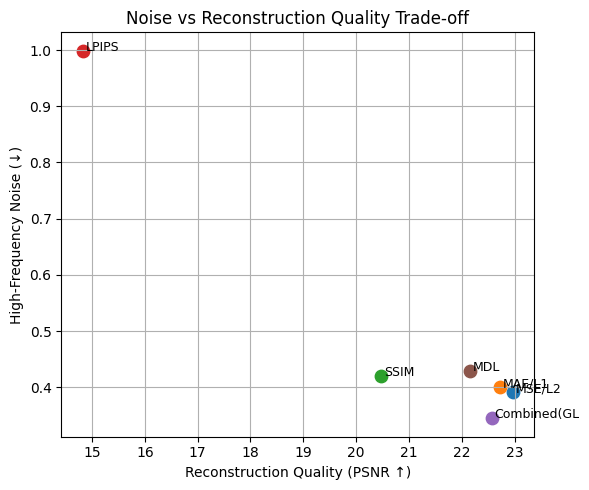

In [25]:
plt.figure(figsize=(8, 6))

for model in df_results.index:
    plt.scatter(
        df_results.loc[model, "PSNR"],
        df_results.loc[model, "HighFreqNoise"],
        s=120,
        alpha=0.85,
        edgecolors="black",
        linewidth=0.8
    )
    plt.text(
        df_results.loc[model, "PSNR"] + 0.1,
        df_results.loc[model, "HighFreqNoise"] + 0.01,
        model.split()[0],
        fontsize=10,
        ha="left",
        va="center"
    )

plt.xlabel("Reconstruction Quality (PSNR ↑)", fontsize=11)
plt.ylabel("High-Frequency Noise (↓)", fontsize=11)
plt.title("Noise vs Reconstruction Quality Trade-off", fontsize=13)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 14b. Running Time

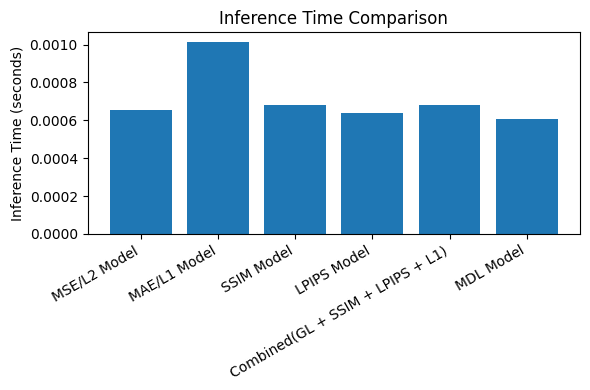

In [26]:
plt.figure(figsize=(6,4))
plt.bar(df_results.index, df_results["InferenceTime(sec)"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Inference Time (seconds)")
plt.title("Inference Time Comparison")
plt.tight_layout()
plt.show()

## 15. Determine BEST RECONSTRUCTION MODEL

In [27]:
df = df_results.copy()

# Invert SSIM so that lower = better for all metrics
df_normalized = df.copy()
df_normalized["SSIM"] = 1.0 - df["SSIM"]

# Min-max normalize all metrics to [0,1]
df_min = df_normalized.min()
df_max = df_normalized.max()
df_norm = (df_normalized - df_min) / (df_max - df_min + 1e-8)

# Final reconstruction score: lower is better
df["ReconstructionScore"] = df_norm.mean(axis=1)

best_reconstruction_model = df["ReconstructionScore"].idxmin()
print("BEST RECONSTRUCTION MODEL:", best_reconstruction_model)

BEST RECONSTRUCTION MODEL: Combined(GL + SSIM + LPIPS + L1)


## 16. Reconstruction Score Bar Chart

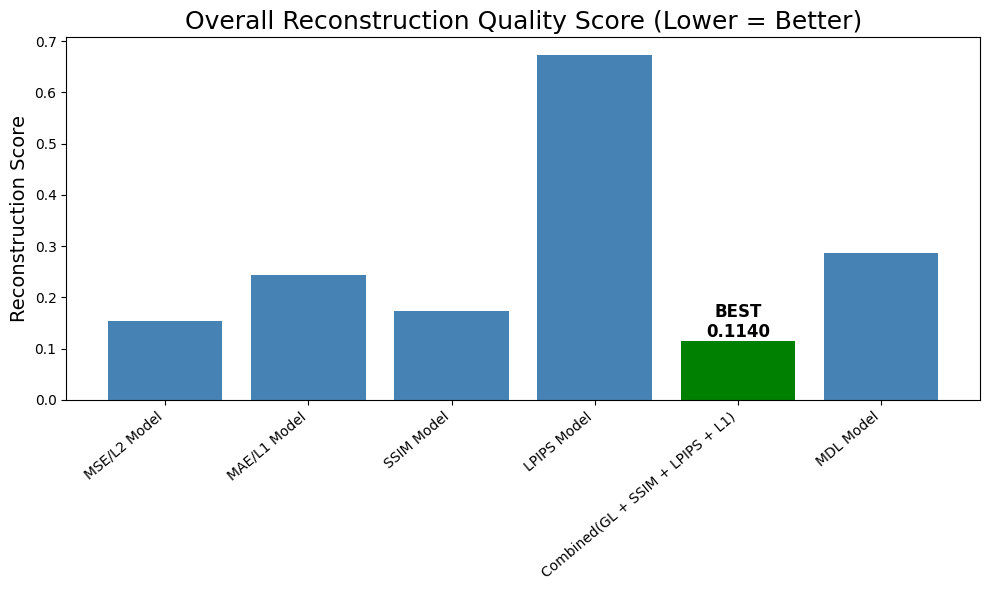

In [28]:

scores = df["ReconstructionScore"]

plt.figure(figsize=(10,6))
colors = ["green" if idx == best_reconstruction_model else "steelblue"
          for idx in df.index]

plt.bar(df.index, scores, color=colors)
plt.title("Overall Reconstruction Quality Score (Lower = Better)", fontsize=18)
plt.ylabel("Reconstruction Score", fontsize=14)
plt.xticks(rotation=40, ha="right")

best_val = scores[best_reconstruction_model]
plt.text(
    df.index.get_loc(best_reconstruction_model),
    best_val,
    f"BEST\n{best_val:.4f}",
    ha="center",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

